# BrainAge Project

In [136]:
import pandas as pd
import numpy as np
import nibabel as nib
from sklearn.model_selection import KFold
from sklearn.svm import SVR
# from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from nilearn.input_data import NiftiMasker

In [122]:
# Parameters
path = './drsulliv3/data/'
n_jobs = 8 #amount of cores
cv=5

In [114]:
# Load subject ids
files = os.listdir(path)
subj = [n[4:9] for n in files if n.startswith('sub')] #here we will filter the file names to leave only subj number as bellow

In [115]:
subjects

['10159',
 '10171',
 '10189',
 '10193',
 '10206',
 '10217',
 '10225',
 '10227',
 '10228',
 '10235']

In [137]:
# Load ages
df = pd.read_csv('participants.tsv', sep='\t')

# take age from subj id
y_age = []
for i in subj:
    a = df.loc[df['participant_id'] == 'sub-'+i] #whole row
    y_age.append(int(a.age))


# # Load IQ
# df = pd.read_csv('add file here', sep='\t')

# # take age from subj id
# y_age = []
# for i in subj:
#     a = df.loc[df['participant_id'] == 'sub-'+i] #whole row
#     y_iq.append(int(a.id))


In [10]:
# # Load volumes for each subject into a dictionary
# d = {}
# for i in range(len(subj)):
#     img = nib.load(path+'sub-'+subj[i]+'_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz').get_fdata()
#     d[subj[i]] = img

# filenames = []
# data = []
# for i in range(len(subj)):
#     img = nib.load(path+'sub-'+subj[i]+'_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz').get_fdata()
#     data.append(img)
#     filenames.append('sub-'+subj[i]+'_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz')

# data  = np.array(data) 

## Let's see the size of a single volume
# data.shape

# # Flatten 3D volume and append to a list (or feed 3D volume to nilearn)
# X = []

# for i in d.values():
#     flattened = i.flatten()
#     X.append(flattened)
    
# # Turn list into array 
# X = np.array(X)

In [125]:
filenames

['sub-10159_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10171_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10189_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10193_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10206_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10217_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10225_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10227_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10228_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10235_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz']

In [126]:
# Affine resample

# from nilearn.image import resample_to_img
# # img = data.affine

# resampled_imgs = []
# resampled_imgs.append(nib.load(path+filenames[0]))
                      
# for i in range(1,len(filenames)):
#     resampled_img = resample_to_img(path+filenames[i], path+filenames[0])
#     resampled_imgs.append(resampled_img)

# for i in resampled_imgs:
#     print(i.affine)

In [128]:
filenames

['sub-10159_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10171_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10189_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10193_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10206_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10217_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10225_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10227_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10228_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-10235_T1w_space_MNI152NLin2009cAsym_preproc.nii.gz']

In [133]:
path_and_filenames = [path+n for n in filenames]

nifti_masker = NiftiMasker(
    standardize=False,
    smoothing_fwhm=2, mask_strategy='epi',
    memory='nilearn_cache')  # cache options
gm_maps_masked = nifti_masker.fit_transform(path_and_filenames)
n_samples, n_features = gm_maps_masked.shape
print("%d samples, %d features" % (4, n_features))

4 samples, 1904516 features


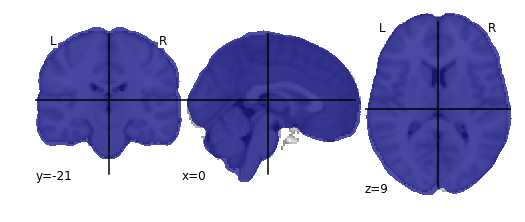

In [134]:
%matplotlib inline
from nilearn import plotting
plotting.plot_roi(nifti_masker.mask_img_)


In [21]:
# Here we split 
X_train, X_test, y_train, y_test = train_test_split(gm_maps_masked, y_age, test_size=0.31, random_state=42)

## Gridsearch 
### Models
* Linear Support vector regressor
    * C = 0.1, 1., 10.

### Feature selection
* ANOVA
    * 2000 features
    * 50000 features
    * Use all features (176*256*256=11534336)

In [150]:
from sklearn.pipeline import Pipeline

# Remove features with too low between-subject variance
# variance_threshold = 

# Here we use a classical univariate feature selection based on F-test,
# namely Anova.
# feature_selection = SelectKBest(f_regression)

# We have our predictor (SVR), our feature selection (SelectKBest), and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
               
               

anova_svr = Pipeline([
            ('variance_threshold', VarianceThreshold(threshold=.01)),
            ('anova', SelectKBest(f_regression)),
            ('svr', SVR())])

# parameters = [{'anova__k': [2000, 100000, 'all'],
#                'svr__C': [0.1, 1, 10]}]

parameters = [{'anova__k': [2000],
               'svr__C': [0.1,1]}]

grid = GridSearchCV(anova_svr, cv=cv, n_jobs=n_jobs, param_grid=parameters, scoring='neg_mean_absolute_error')
grid.fit(gm_maps_masked, y_age)



# mean_scores = np.array(grid.cv_results_['neg_mean_absolute_error'])
# mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# # select score for best C
# mean_scores = mean_scores.max(axis=0)
# bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
#                (len(reducer_labels) + 1) + .5)






/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variance_threshold', VarianceThreshold(threshold=0.01)), ('anova', SelectKBest(k=10, score_func=<function f_regression at 0x111cfaea0>)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid=[{'anova__k': [2000], 'svr__C': [0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [153]:
print('best score: ',grid.best_score_)
print('best params: ',grid.best_params_)
print('\n\nfullresults: \n', grid.cv_results_)
df1 = pd.DataFrame(grid.cv_results_)
df1

best score:  -7.090000000000001
best params:  {'anova__k': 2000, 'svr__C': 1}


fullresults: 
 {'mean_fit_time': array([11.96528947, 11.9117009 ]), 'std_fit_time': array([0.53389108, 0.42364206]), 'mean_score_time': array([1.82528949, 1.82144833]), 'std_score_time': array([0.08027539, 0.14242572]), 'param_anova__k': masked_array(data=[2000, 2000],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_svr__C': masked_array(data=[0.1, 1],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'anova__k': 2000, 'svr__C': 0.1}, {'anova__k': 2000, 'svr__C': 1}], 'split0_test_score': array([-9.33333333, -9.33333333]), 'split1_test_score': array([-7.        , -6.96666667]), 'split2_test_score': array([-2., -2.]), 'split3_test_score': array([-9., -9.]), 'mean_test_score': array([-7.1 , -7.09]), 'std_test_score': array([2.72457948, 2.7249893 ]), 'rank_test_score': array([2, 1], dtype=int32), 'split0_train_score': arra

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_scor

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_anova__k,param_svr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,11.965289,0.533891,1.825289,0.080275,2000,0.1,"{'anova__k': 2000, 'svr__C': 0.1}",-9.333333,-7.000000,-2.0,-9.0,-7.10,2.724579,2,-5.771429,-6.771429,-8.025,-6.275,-6.710714,0.837129
1,11.911701,0.423642,1.821448,0.142426,2000,1,"{'anova__k': 2000, 'svr__C': 1}",-9.333333,-6.966667,-2.0,-9.0,-7.09,2.724989,1,-5.000000,-6.014286,-7.125,-5.400,-5.884821,0.801992


In [149]:
age_pred = grid.predict(gm_maps_masked)
np.mean(np.abs(age_pred-y_age))
y_age

[30, 24, 49, 40, 21, 33, 35, 31, 40, 22]

In [ ]:
# r2 score